In [80]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


In [81]:
cab_df = pd.read_csv(r'F:\Dataset\Datasets/cab_rides.csv')
weather_df = pd.read_csv(r'F:\Dataset\Datasets/weather.csv')

In [82]:
weather_df.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [83]:
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [84]:
cab_df[cab_df['cab_type']=='Lyft']['surge_multiplier'].value_counts()

1.00    286433
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: surge_multiplier, dtype: int64

In [85]:
weather_df = weather_df.fillna(0)

In [86]:
cab_df["rounded_timestamp"] = cab_df["time_stamp"] / 1000
cab_df["rounded_timestamp"] = cab_df["rounded_timestamp"].apply(np.floor)

cab_df["date"] = cab_df["rounded_timestamp"].apply(lambda x : datetime.fromtimestamp(x).date())
cab_df["time"] = cab_df["rounded_timestamp"].apply(lambda x: datetime.fromtimestamp(x).time())
cab_df['weekday'] = cab_df['date'].apply(lambda x: x.weekday())
cab_df["weekday"] = cab_df["weekday"].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
cab_df['hour'] = cab_df['time'].apply(lambda time: time.hour)

cab_df.loc[(cab_df.hour >= 6) & (cab_df.hour < 12) , 'time_of_day'] = 'Morning'
cab_df.loc[(cab_df.hour >= 12) & (cab_df.hour < 15) , 'time_of_day'] = 'Afternoon'
cab_df.loc[(cab_df.hour >= 15) & (cab_df.hour < 18) , 'time_of_day'] = 'Evening'
cab_df.loc[(cab_df.hour >= 18) | (cab_df.hour < 6) , 'time_of_day'] = 'Night'

In [87]:
cab_df['cab_type'].value_counts()

Uber    385663
Lyft    307408
Name: cab_type, dtype: int64

In [88]:
uber_df = cab_df[cab_df['cab_type'] =="Uber"]
lyft_df = cab_df[cab_df['cab_type'] =="Lyft"]

In [89]:
lyft_df = cab_df[cab_df["cab_type"] == "Lyft"]
uber_ds = cab_df[cab_df['cab_type'] == "Uber"]

uber_ds_corr = uber_ds[["distance", "price", "surge_multiplier"]]
lyft_df_corr = lyft_df[["distance", "price", "surge_multiplier"]]

<AxesSubplot:>

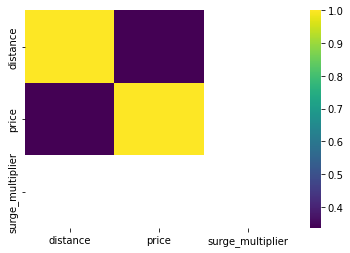

In [90]:
sns.heatmap(uber_ds_corr.corr(), cmap="viridis")

<AxesSubplot:>

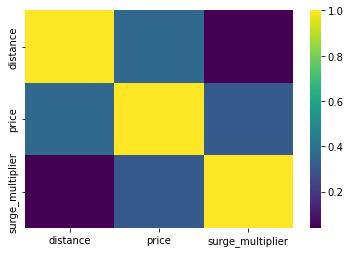

In [91]:
sns.heatmap(lyft_df_corr.corr() , cmap="viridis")

In [92]:
uber_df["surge_multiplier"].value_counts()


1.0    385663
Name: surge_multiplier, dtype: int64

In [93]:
lyft_df["surge_multiplier"].value_counts()

1.00    286433
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: surge_multiplier, dtype: int64

In [94]:
high_surge_dataset = lyft_df[lyft_df["surge_multiplier"]> 1]

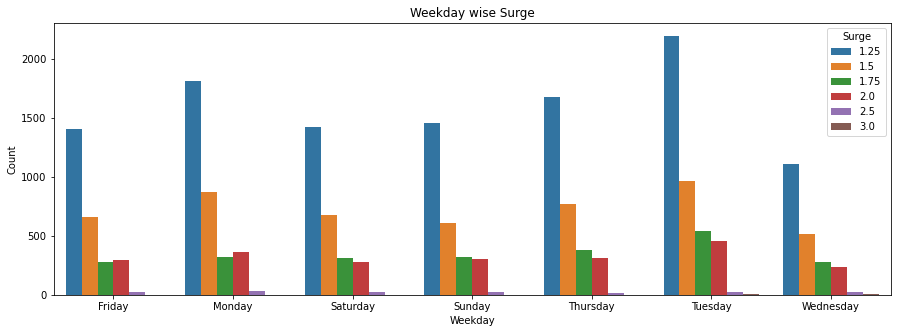

In [95]:
t_high_surge = pd.DataFrame(high_surge_dataset.groupby(["weekday", "surge_multiplier"]).size().reset_index())
t_high_surge.columns = ["Weekday", "Surge", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(x="Weekday", y="Count", hue="Surge", data=t_high_surge).set_title("Weekday wise Surge");

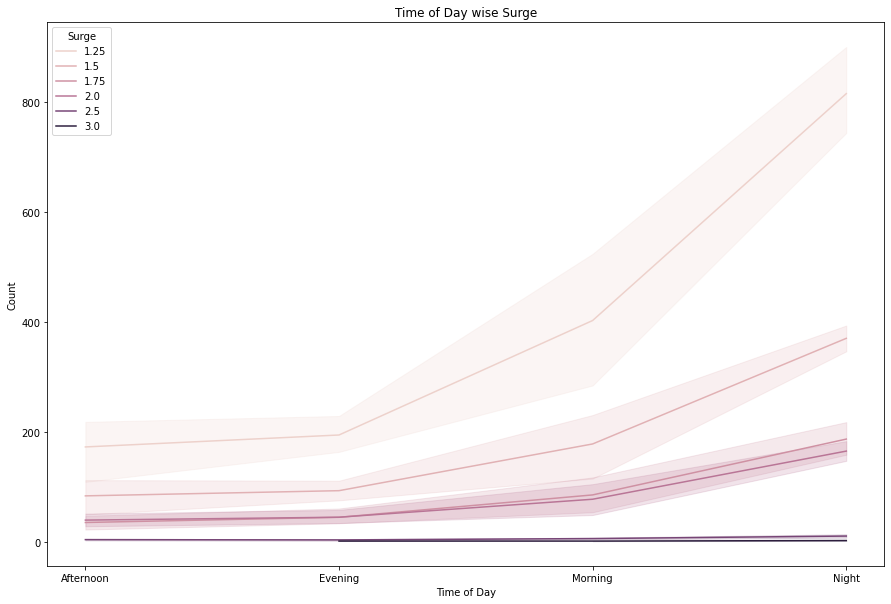

In [96]:
td_high_surge = pd.DataFrame(high_surge_dataset.groupby(["weekday", "surge_multiplier","time_of_day"]).size().reset_index())
td_high_surge.columns = ["Weekday", "Surge", "Time of Day", "Count"]

plt.figure(figsize=(15, 10))
sns.lineplot(x="Time of Day", y="Count", hue="Surge", data=td_high_surge).set_title("Time of Day wise Surge");

In [97]:
# ### Surge and Distance

# Now lets try to study the surge, price and distance. We are trying to see if one of the value affects another for both the brands.

In [98]:
uber_dis_price_surge = uber_df[['distance', 'surge_multiplier', 'price']]
lyft_dis_price_surge = lyft_df[['distance', 'surge_multiplier', 'price']]

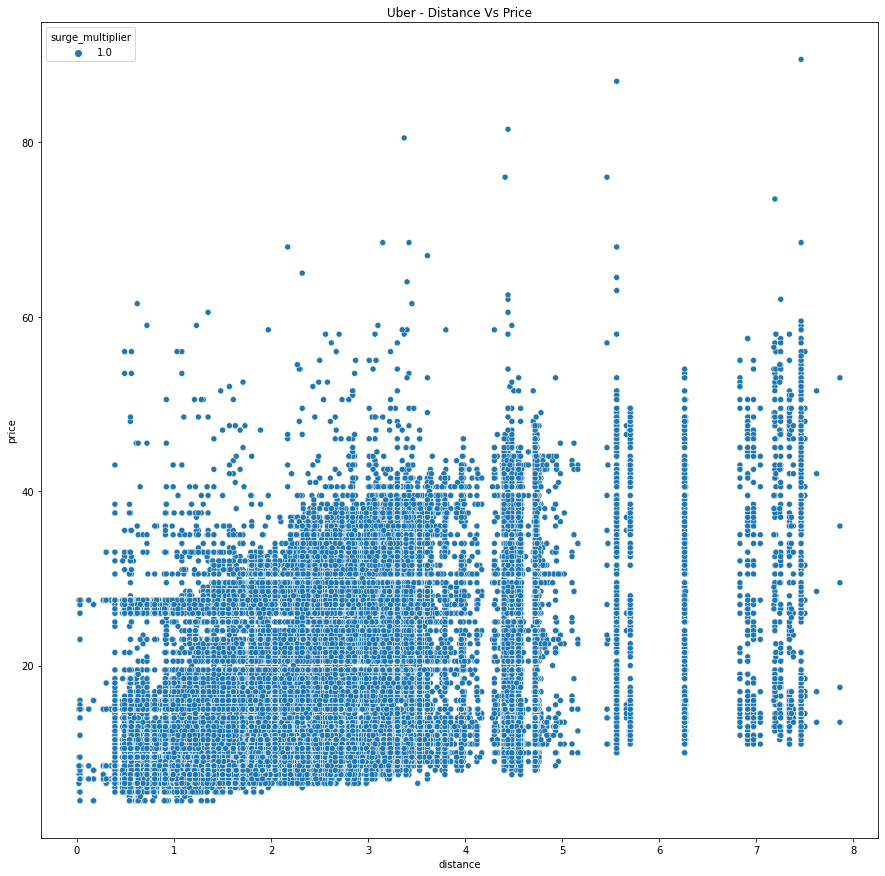

In [99]:
plt.figure(figsize=(15, 15))
sns.scatterplot(data=uber_dis_price_surge, x="distance", y="price", hue="surge_multiplier").set_title("Uber - Distance Vs Price");

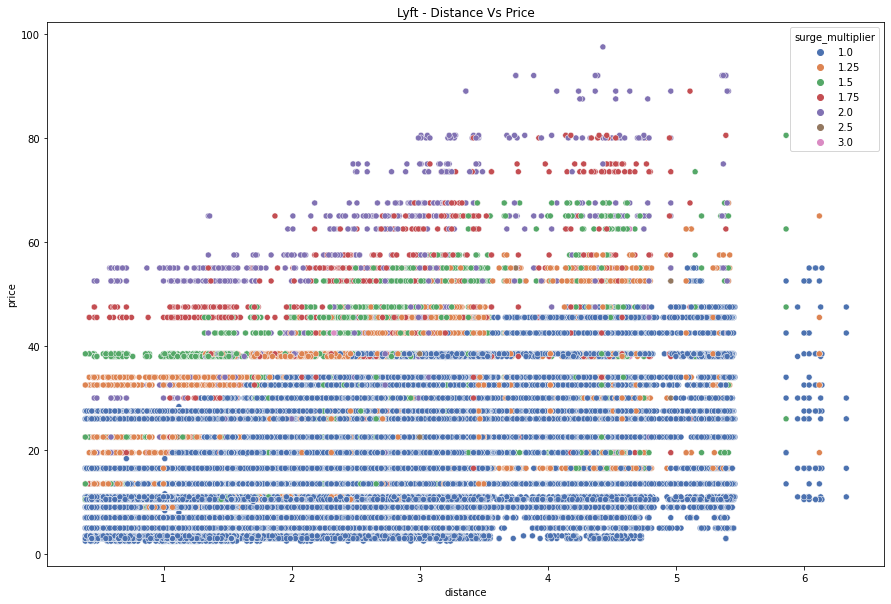

In [100]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=lyft_dis_price_surge, x="distance", y="price", hue="surge_multiplier", palette="deep").set_title("Lyft - Distance Vs Price");

In [101]:
#Top 5 Source destinations

In [102]:
#For Uber

In [103]:
uber_s_d_df= uber_df.groupby(['source', "destination"]).size().reset_index()
uber_s_d_df.columns = ["source", "destination", "count"]
uber_s_d_df.sort_values("count", inplace=True, ascending = False)
uber_five_most = uber_s_d_df.iloc[0:5, ]
uber_five_most["Source - Destination"] = uber_s_d_df["source"] + " - " + uber_s_d_df["destination"]


C:\Users\Asif\AppData\Local\Temp\ipykernel_11140\1496741863.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_five_most["Source - Destination"] = uber_s_d_df["source"] + " - " + uber_s_d_df["destination"]


In [104]:
uber_five_most = uber_five_most[["Source - Destination", "count"]]
uber_five_most

,Source - Destination,count
29,Financial District - South Station,5726
56,South Station - Financial District,5726
36,North End - Back Bay,5677
3,Back Bay - North End,5677
67,West End - Fenway,5635


In [105]:
# For Lyft

In [106]:
lyft_s_d_df= lyft_df.groupby(['source', "destination"]).size().reset_index()
lyft_s_d_df.columns = ["source", "destination", "count"]
lyft_s_d_df.sort_values("count", inplace=True, ascending = False)
lyft_five_most = lyft_s_d_df.iloc[0:5, ]
lyft_five_most["Source - Destination"] = lyft_s_d_df["source"] + " - " + lyft_s_d_df["destination"]

C:\Users\Asif\AppData\Local\Temp\ipykernel_11140\1233783840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft_five_most["Source - Destination"] = lyft_s_d_df["source"] + " - " + lyft_s_d_df["destination"]


In [107]:
lyft_five_most = lyft_five_most[["Source - Destination", "count"]]
lyft_five_most

,Source - Destination,count
56,South Station - Financial District,4626
29,Financial District - South Station,4626
36,North End - Back Bay,4548
3,Back Bay - North End,4548
67,West End - Fenway,4530


In [108]:
# Which destinations attract more surge and which are least

# Here we pick only those rows which have surge greater than or equal to 2

In [109]:
high_surge_rows = cab_df[cab_df["surge_multiplier"] >= 2]
loc_wise_surge = high_surge_rows.groupby(["source", "destination"]).size().reset_index()

C:\Users\Asif\AppData\Local\Temp\ipykernel_11140\1743283177.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  destination_surge_df = highest_destination_surge.append(lowest_destination_surge, ignore_index=True)


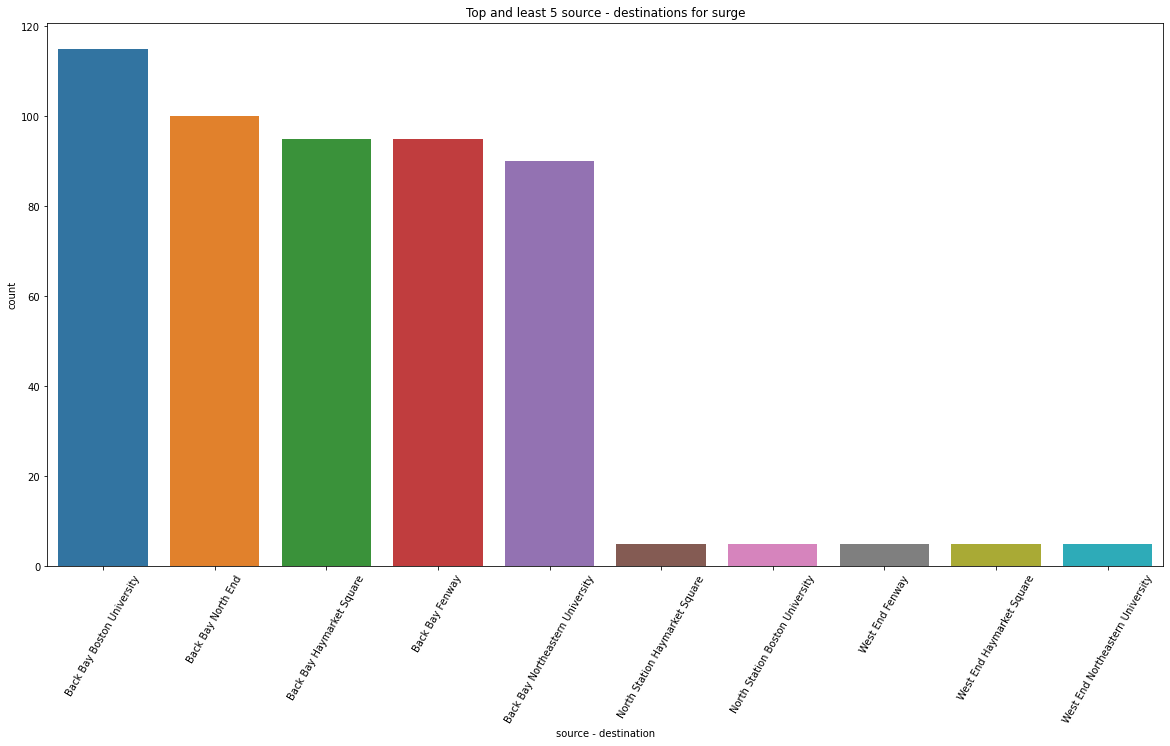

In [110]:
loc_wise_surge.columns=["source", "destination", "count"]
loc_wise_surge.sort_values(inplace=True, ascending=False, by=["count"])


highest_destination_surge = loc_wise_surge.head(5)
lowest_destination_surge = loc_wise_surge.tail(5)
# highest_destination_surge
destination_surge_df = highest_destination_surge.append(lowest_destination_surge, ignore_index=True)
destination_surge_df["source - destination"] = destination_surge_df["source"] + " " + destination_surge_df["destination"]
plt.figure(figsize=(20, 10))
g = sns.barplot(data = destination_surge_df, x = "source - destination", y = "count")
g.set_title("Top and least 5 source - destinations for surge")
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=60);

In [111]:
# ### Shared Rides
# 
# <p> In the Lyft rides, we can see that there are some shared rides as well. </p>
# <p> Now, lets see when do people want to have these </p>

In [112]:
lyft_df["name"].value_counts()

Lux             51235
Lyft            51235
Lux Black XL    51235
Lyft XL         51235
Lux Black       51235
Shared          51233
Name: name, dtype: int64

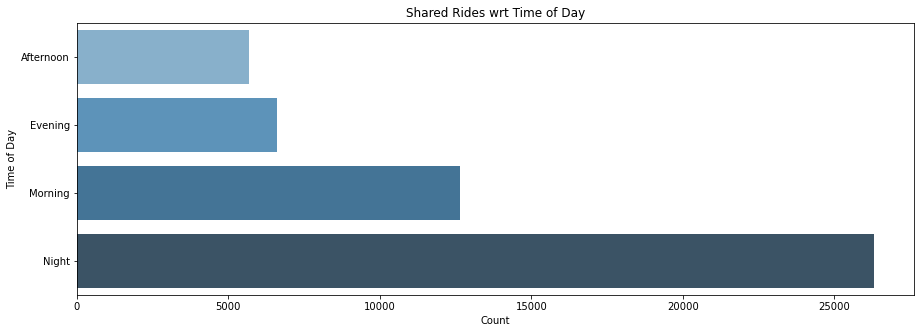

In [113]:
lyft_shared_rides_df = lyft_df[lyft_df["name"] == "Shared"]
lyft_shared_ride_td = lyft_shared_rides_df.groupby(["name", "time_of_day"]).size().reset_index()
lyft_shared_ride_td.columns = ["Name", "Time of Day", "Count"]
plt.figure(figsize=(15, 5))
sns.barplot(y="Time of Day", x="Count", data=lyft_shared_ride_td, palette="Blues_d", orient ='h' ).set_title("Shared Rides wrt Time of Day");

In [114]:
# ### Shared rides with Distance and Price
# 
# Does the Distance and Price affect the Shared Rides? Lets try to understand

In [115]:
lyft_shared_rides_distance_price = lyft_shared_rides_df.groupby(["name", "distance", "price"]).size().reset_index()
lyft_shared_rides_distance_price.columns = ["name", "distance", "price", "count"]


In [116]:
lyft_shared_rides_distance_price

,name,distance,price,count
0,Shared,0.39,2.5,1
1,Shared,0.39,3.0,4
2,Shared,0.39,3.5,1
3,Shared,0.39,5.0,36
4,Shared,0.39,7.0,1
...,...,...,...,...
2778,Shared,6.12,10.5,1
2779,Shared,6.12,13.5,1
2780,Shared,6.13,11.0,1
2781,Shared,6.14,10.5,1


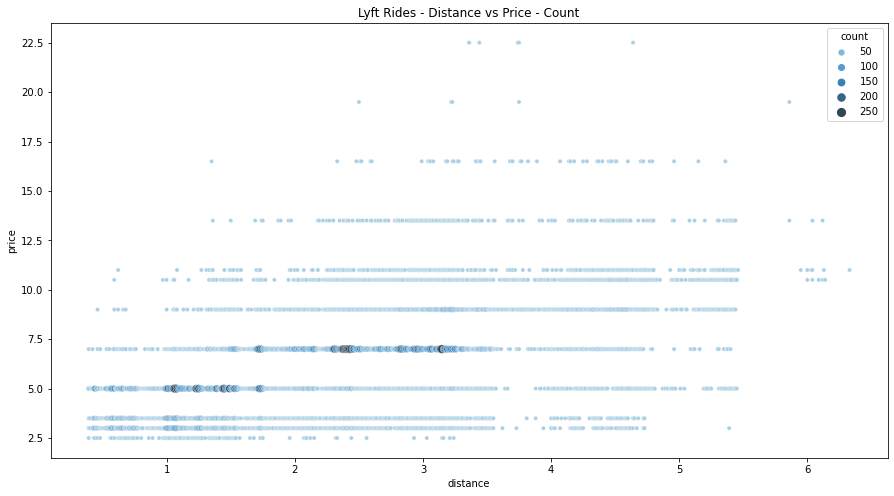

In [117]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data = lyft_shared_rides_distance_price, palette="Blues_d" , x = "distance", y="price", hue="count", size="count").set_title("Lyft Rides - Distance vs Price - Count");

In [118]:
#For Weather Dataset

In [119]:
weather_df["time_stamp"] = weather_df["time_stamp"] / 1000
weather_df["time_stamp"] = weather_df["time_stamp"].apply(np.floor)

In [120]:
weather_df["time_stamp"] = weather_df["time_stamp"].astype(int)


In [121]:
weather_df.columns = ['temp', 'source', 'clouds', 'pressure', 'rain', 'time_stamp', 'humidity', 'wind']

In [122]:
weather_df.isnull().sum()

temp          0
source        0
clouds        0
pressure      0
rain          0
time_stamp    0
humidity      0
wind          0
dtype: int64

In [123]:
merged_data = pd.merge(weather_df, weather_df, on=["source", "time_stamp"])


In [124]:
tmp_merged_data = merged_data[['temp', 'source', 'time_stamp', 'cab_type', 'destination',
       'surge_multiplier',  'name']]

KeyError: "['temp', 'cab_type', 'destination', 'surge_multiplier', 'name'] not in index"

In [64]:
merged_data.shape

(10404, 14)

In [67]:
merged_data.to_csv(r'F:\Dataset\Datasets/Visualizationmergerged.csv', index=True)